In [1]:
import json
import copy
import numpy as np
from torch import nn, tensor
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset
-   Loading train, test, validation set using 'JSON' library
-   Investigating through dataset with an example
-   Creating function to map 'srl_frames'
-   Implement fucntion to fix the length of lists 

### Train set

In [2]:
with open('data/train.json', 'r') as my_file:
    train_set = json.load(my_file)

### Test set

In [3]:
with open('data/test.json', 'r') as my_file:
    test_set = json.load(my_file)

### Valid set

In [4]:
with open('data/valid.json', 'r') as my_file:
    valid_set = json.load(my_file)

In [5]:
keys_list = [key for key in train_set.keys()]

### Investingating dataset with an example

In [6]:
for key in keys_list:
    print(f'The second {key} in traingin set is: {train_set[key][1]}')

The second text in traingin set is: ['The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.']
The second srl_frames in traingin set is: ['O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
The second verb_index in traingin set is: 4
The second words_indices in traingin set is: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


### Create a function to map them 

In [7]:
mapper_dict = {
    'O': 0,
    'B-ARG0': 1,
    'I-ARG0': 2,
    'B-ARG1': 3,
    'I-ARG1': 4,
    'B-ARG2': 5,
    'I-ARG2': 6,
    'B-ARGM-LOC': 7,
    'I-ARGM': 8,
    'B-ARGM-TMP':9,
    'I-ARGM-TMP':10
}
def mapping_dictionary(mapper:dict, srl_labels:list[list[str]]) -> list[list[int]]:
    """
        First padding to fix the output length
        Then simply maps the srl_frames to the tagset
    """
    max_length = max((len(labels) for labels in srl_labels), default=0)
    labels = [[0 for _ in tags] for tags in srl_labels]
    for index, tag_list in enumerate(srl_labels):
        if len(tag_list) < max_length:
            for j in range(max_length-len(tag_list)):
                labels[index].append(0)     
        for i, tag in enumerate(tag_list):
            labels[index][i] = mapper[tag]
    return labels

### Padding Function

In [8]:
def Padding(given_set:dict, max_length:int, Pad_token='<PAD>') -> dict:
    """
        Adding pad token to the list in order to fix the sizes the sentences
    """
    for index, token_list in enumerate(given_set['text']):
        if len(token_list) < max_length:
            for j in range(max_length - len(token_list)):
                given_set['text'][index].append(Pad_token)
    return given_set

### Create Vocab Class

In [9]:
class Vocab(object):
    def __init__(self, word2id:dict) -> None:
        """
            If word2id is None then it would be initialized by a dictionary otherwise will be initialized by word2id's value
        """
        self.word2id = {'<PAD>': 0,'<Start>': 1,'<End>': 2,'<Unknown>': 3} if word2id is None else word2id
        self.id2word = {value:key for key, value in self.word2id.items()}
    
    def __getitem__(self, word) -> int:
        """
            return the word's key in word2id. If the word does not exist return id of Uknown word.
        """
        if word in self.word2id:
            return self.word2id[word]
        return self.word2id['<Unknown>']
    
    def __len__(self) -> int:
        """
            Return the vocab size
        """
        return len(self.word2id)


    def add(self, word : str) -> int:
        """
            Add a word if it is not already in vocab and return the index of added word
        """
        if word not in self.word2id:
            length = len(self.word2id)
            self.word2id[word] = length
            self.id2word[length] = word
            return length

    def word2indices(self, sents:list[list[str]]) -> list[list[int]]:
        """
            Get list of sentences and returns the corresponding indices in vocab dictionary
        """
        indices = [[0 for _ in sentence] for sentence in sents]
        for i,tokens in enumerate(sents):
            for j,token in enumerate(tokens):
                indices[i][j] = self[token]
        return indices

    def indices2words(self, word_ids:list[list[int]]) -> list[list[str]]:
        """
            This will get list of indexes as an input and return the corresponding ids
        """
        words = [['help' for _ in index_list] for index_list in word_ids]
        for i,index_list in enumerate(word_ids):
            for j, index in enumerate(index_list):
                words[i][j] = self.id2word[index]
        return words

    def to_input_tensor(self, sents:list[list[str]]) -> list[list[tensor]]:
        """
            First padding the sentences then\\
            convert sentences to indexes and turn them into tensors
        """
        temp_sents = copy.deepcopy(sents)
        max_length = max((len(sentence) for sentence in sents), default=0)
        for i,sentence in enumerate(temp_sents):
            if(len(sentence) < max_length):
                for _ in range(max_length - len(sentence)):
                    temp_sents[i].append('<PAD>')
        return tensor(self.word2indices(temp_sents), dtype=torch.long)

### Implementing from_corpus function

In [10]:
def from_corpus(corpus: list[list[str]], size:int, remove_frac:float, freq_cutoff:int) -> Vocab:
    """
        Getting an instance of Vocab class and add words by add method    
    """
    vocab_model = Vocab(None)
    word_freq = {}
    for token_list in corpus:
        for token in token_list:
            if token in word_freq:
                word_freq[token] += 1
            else:
                word_freq[token] = 1
    sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1])
    num_items = len(sorted_word_freq)
    num_to_remove = int(num_items * remove_frac)
    remaingin_items = sorted_word_freq[num_to_remove:]
    remaingin_items = dict(remaingin_items)
    for word,count in remaingin_items.items():
        if len(vocab_model) >= size:
            break
        if count >= freq_cutoff:
            vocab_model.add(word)
    return vocab_model


In [11]:
vocab = from_corpus(train_set['text'], size=20000, remove_frac=0.3, freq_cutoff=1)

In [12]:
vocab.word2id

{'<PAD>': 0,
 '<Start>': 1,
 '<End>': 2,
 '<Unknown>': 3,
 'Fangbo': 4,
 'Cai': 5,
 'cocktail': 6,
 'entertaining': 7,
 'Reporter': 8,
 'Qixin': 9,
 'attache': 10,
 'Monitor': 11,
 'silt': 12,
 'Summer': 13,
 'inconsistent': 14,
 'subjective': 15,
 'lamps': 16,
 'cliffs': 17,
 'deserted': 18,
 'abundance': 19,
 'fortress': 20,
 'kernel': 21,
 'uniting': 22,
 'multi-faceted': 23,
 'talents': 24,
 'remittance': 25,
 'Sackler': 26,
 'Calligraphy': 27,
 'calligraphy': 28,
 'treasures': 29,
 'calligraphers': 30,
 'sacred': 31,
 'charisma': 32,
 'inordinate': 33,
 'narrowed': 34,
 'moreover': 35,
 'sloping': 36,
 'Touring': 37,
 'imply': 38,
 'scenery': 39,
 "y'": 40,
 'Chrysanthemum': 41,
 'geosynchronous': 42,
 'upsurge': 43,
 'conservation': 44,
 'painstaking': 45,
 'Baltic': 46,
 'Lithuania': 47,
 'Latvia': 48,
 'Estonia': 49,
 '29th': 50,
 'Botanical': 51,
 'sprouted': 52,
 'buds': 53,
 'balconies': 54,
 'potted': 55,
 'blossoms': 56,
 'scarlet': 57,
 'observe': 58,
 'asteroids': 59,
 '

# LSTM

In [13]:
class LSTM_Based(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim) -> None:
        super(LSTM_Based, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.output_dim = output_dim
    
    def forward(self, sentences, predicate_indices):
        embedded = self.word_embeddings(sentences)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        predicate_hidden = lstm_out[torch.arange(len(predicate_indices)), predicate_indices]
        predicate_hidden_expanded = predicate_hidden.unsqueeze(1).expand(-1, lstm_out.size(1), -1)
        enhanced_hidden = torch.cat((lstm_out, predicate_hidden_expanded), dim=2)
        output = self.fc(enhanced_hidden)
        return output

### Create a custom dataset

In [14]:
class Custom_Dataset(Dataset):
    def __init__(self, input_set:dict) -> None:
        """
            Specify the dataset as a dictionary
        """
        self.txt = input_set['text']
        self.verb = input_set['verb_index']
        self.labels = input_set['srl_frames']

    def __len__(self):
        return len(self.txt)
    
    def __getitem__(self, index):
        return self.txt[index], self.verb[index], self.labels[index]

In [15]:
train_dataset = Custom_Dataset(input_set=train_set)

### Collate batch

In [16]:
def collate_batch_1(batch, vocab:Vocab, mapping_dict:dict):
    text = []
    verb_index = []
    labels = []
    for b in batch:
        text.append(b[0])
        verb_index.extend([b[1]])
        labels.append(b[2])
    txt_tensor = vocab.to_input_tensor(text)
    verb_index_tensor = tensor(verb_index, dtype=torch.long)
    labels_tensor = tensor(mapping_dictionary(mapping_dict, labels), dtype=torch.long)
    return txt_tensor, verb_index_tensor, labels_tensor

In [17]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=lambda batch : collate_batch_1(batch, vocab=vocab, mapping_dict=mapper_dict)
)

### Visulaization a batch by data loader

In [18]:
for batch in train_dataloader:
    text = batch[0].tolist()
    verb_indices = batch[1].tolist()
    srl_labels = batch[2].tolist()
    break
print(vocab.indices2words(text))
print(verb_indices)
print(srl_labels)
print(batch[0].shape, batch[1].shape, batch[2].shape)

[['Then', 'I', 'heard', 'the', 'third', 'living', 'being', 'say', ',', '``', 'Come', '!', "''", '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'], ['Setting', 'up', 'an', 'Internet', 'business', ':', 'What', 'do', 'you', 'need', '?', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'], ['Showtime', 'is', 'a', 'distant', 'No.', '2', 'to', 'Home', 'Box', 'Office', ',', 'and', 'in', 'May', 'filed', 'a', '$', '2.5', 'billion', 'antitrust', 'suit', 'again

In [19]:
my_lstm = LSTM_Based(vocab_size=len(vocab), embedding_dim=64, hidden_dim=64, output_dim=50)
print(my_lstm)

LSTM_Based(
  (word_embeddings): Embedding(13362, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=128, out_features=50, bias=True)
)


### Validate loops

In [20]:
def validation(model, val_loader, loss_fn, device="cuda"):
    val_loss = 0
    model.eval()
    reals = []
    all_preds = []
    for batch in val_loader:
        sentence = batch[0].to(device)
        verb_indices = batch[1].to(device)
        labels = batch[2].to(device)
        with torch.no_grad():
            preds = model(sentence, verb_indices)
        loss = loss_fn(preds.view(-1, model.output_dim), labels.view(-1))
        val_loss += loss.item()
        all_preds.extend(preds.view(-1, model.output_dim).argmax(axis=1).cpu().numpy().tolist())
        reals.extend(labels.view(-1).cpu().numpy().tolist())
    val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(reals, all_preds)
    return val_loss, accuracy, reals, all_preds

### Training loops

In [21]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device="cuda"):
    accuracy_per_epoch = []
    loss_per_epoch = []
    val_loss_per_epoch = []
    val_accuracy_per_epoch = []
    reals, all_preds = [], []
    model.to(device)
    for epoch in range(epochs):
        training_loss = 0
        whole_predictions = []
        whole_labals = []
        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            sentences = batch[0].to(device)
            verb_indices = batch[1].to(device)
            srl_labels = batch[2].to(device)
            preds = model(sentences, verb_indices)
            loss = loss_fn(preds.view(-1, model.output_dim), srl_labels.view(-1))
            loss.backward()
            training_loss += loss.item()
            optimizer.step()
            whole_predictions.extend(preds.view(-1, model.output_dim).argmax(axis=1).cpu().numpy().tolist())
            whole_labals.extend(srl_labels.view(-1).cpu().numpy().tolist())
        training_loss = training_loss/len(train_loader)
        train_accuracy = accuracy_score(whole_predictions, whole_labals)
        loss_per_epoch.append(training_loss)
        accuracy_per_epoch.append(train_accuracy)
        print(f'Epoch: {epoch}, training_loss: {training_loss:.2f}, train accuracy {train_accuracy:.2f}')
        val_loss, val_accuracy, reals, all_preds = validation(model, val_loader, loss_fn, device)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)
        print(f'validation loss: {val_loss:.2f}, validation accuracy: {val_accuracy:.2f}')
    print(classification_report(reals, all_preds))
    return loss_per_epoch, accuracy_per_epoch, val_loss_per_epoch, val_accuracy_per_epoch

In [22]:
epoch = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_lstm = LSTM_Based(vocab_size=len(vocab), embedding_dim=64, hidden_dim=64, output_dim=11)
optimizer = torch.optim.AdamW(my_lstm.parameters(), lr=0.005)
loss_fn = torch.nn.CrossEntropyLoss()
train_dataset = Custom_Dataset(input_set=train_set)
validate_dataset = Custom_Dataset(input_set=valid_set)
train_loader = DataLoader(train_dataset,
    batch_size=64, 
    shuffle=True, 
    drop_last=True,
    collate_fn=lambda batch:collate_batch_1(batch, vocab=vocab, mapping_dict=mapper_dict)
)
validate_loader = DataLoader(validate_dataset,
    batch_size=64, 
    shuffle=True, 
    drop_last=True,
    collate_fn=lambda batch:collate_batch_1(batch, vocab=vocab, mapping_dict=mapper_dict)
)

In [23]:
train_loss, train_accuracy, val_loss, val_accuracy = train(model=my_lstm, optimizer=optimizer, loss_fn=loss_fn, train_loader=train_loader, val_loader=validate_loader, epochs=epoch, device=device)

100%|██████████| 207/207 [00:02<00:00, 94.63it/s] 


Epoch: 0, training_loss: 0.36, train accuracy 0.92
validation loss: 0.31, validation accuracy: 0.92


100%|██████████| 207/207 [00:01<00:00, 124.62it/s]


Epoch: 1, training_loss: 0.24, train accuracy 0.93
validation loss: 0.28, validation accuracy: 0.92


100%|██████████| 207/207 [00:01<00:00, 136.96it/s]


Epoch: 2, training_loss: 0.21, train accuracy 0.93
validation loss: 0.27, validation accuracy: 0.92


100%|██████████| 207/207 [00:01<00:00, 132.75it/s]


Epoch: 3, training_loss: 0.18, train accuracy 0.94
validation loss: 0.29, validation accuracy: 0.91


100%|██████████| 207/207 [00:01<00:00, 124.00it/s]


Epoch: 4, training_loss: 0.16, train accuracy 0.95
validation loss: 0.29, validation accuracy: 0.91


100%|██████████| 207/207 [00:01<00:00, 116.47it/s]


Epoch: 5, training_loss: 0.14, train accuracy 0.95
validation loss: 0.31, validation accuracy: 0.90


100%|██████████| 207/207 [00:01<00:00, 109.09it/s]


Epoch: 6, training_loss: 0.12, train accuracy 0.96
validation loss: 0.32, validation accuracy: 0.90


100%|██████████| 207/207 [00:02<00:00, 96.84it/s] 


Epoch: 7, training_loss: 0.11, train accuracy 0.96
validation loss: 0.33, validation accuracy: 0.90


100%|██████████| 207/207 [00:01<00:00, 135.13it/s]


Epoch: 8, training_loss: 0.10, train accuracy 0.96
validation loss: 0.34, validation accuracy: 0.91


100%|██████████| 207/207 [00:01<00:00, 127.63it/s]


Epoch: 9, training_loss: 0.09, train accuracy 0.97
validation loss: 0.37, validation accuracy: 0.90
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     33952
           1       0.45      0.36      0.40       341
           2       0.24      0.26      0.25       282
           3       0.37      0.27      0.31       639
           4       0.27      0.31      0.28      1008
           5       0.48      0.36      0.41       214
           6       0.37      0.35      0.36       481
           7       0.00      0.00      0.00        10
           9       0.60      0.37      0.46        65

    accuracy                           0.90     36992
   macro avg       0.41      0.36      0.38     36992
weighted avg       0.90      0.90      0.90     36992



C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


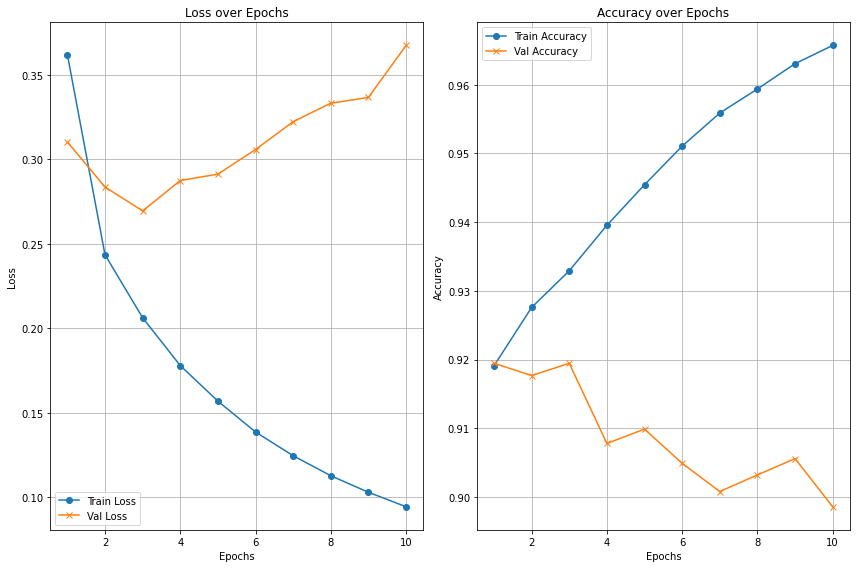

In [24]:
import matplotlib.pyplot as plt
epochs = np.arange(1, len(train_loss) + 1)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label = 'Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Loss over Epochs')
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Val Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.show()

### GRU implementation 

In [25]:
class GRU_Baesd(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRU_Baesd, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.output_dim = output_dim
    
    def forward(self, sentences, predicate_indices):
        embeded = self.word_embedding(sentences)
        gru_out, _ = self.gru(embeded)
        predicate_hidden = gru_out[torch.arange(len(predicate_indices)), predicate_indices]
        predicate_hidden_expanded = predicate_hidden.unsqueeze(1).expand(-1, gru_out.size(1), -1)
        enhanced_hidden = torch.cat((gru_out, predicate_hidden_expanded), dim=2)
        output = self.fc(enhanced_hidden)
        return output

### Validation will be same for GRU

In [26]:
def validation(model, val_loader, loss_fn, device="cuda"):
    val_loss = 0
    model.eval()
    reals = []
    all_preds = []
    for batch in val_loader:
        sentence = batch[0].to(device)
        verb_indices = batch[1].to(device)
        labels = batch[2].to(device)
        with torch.no_grad():
            preds = model(sentence, verb_indices)
        loss = loss_fn(preds.view(-1, model.output_dim), labels.view(-1))
        val_loss += loss.item()
        all_preds.extend(preds.view(-1, model.output_dim).argmax(axis=1).cpu().numpy().tolist())
        reals.extend(labels.view(-1).cpu().numpy().tolist())
    val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(reals, all_preds)
    return val_loss, accuracy, reals, all_preds

### Training also will be same

In [27]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device="cuda"):
    accuracy_per_epoch = []
    loss_per_epoch = []
    val_loss_per_epoch = []
    val_accuracy_per_epoch = []
    reals, all_preds = [], []
    model.to(device)
    for epoch in range(epochs):
        training_loss = 0
        whole_predictions = []
        whole_labals = []
        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            sentences = batch[0].to(device)
            verb_indices = batch[1].to(device)
            srl_labels = batch[2].to(device)
            preds = model(sentences, verb_indices)
            loss = loss_fn(preds.view(-1, model.output_dim), srl_labels.view(-1))
            loss.backward()
            training_loss += loss.item()
            optimizer.step()
            whole_predictions.extend(preds.view(-1, model.output_dim).argmax(axis=1).cpu().numpy().tolist())
            whole_labals.extend(srl_labels.view(-1).cpu().numpy().tolist())
        training_loss = training_loss/len(train_loader)
        train_accuracy = accuracy_score(whole_predictions, whole_labals)
        loss_per_epoch.append(training_loss)
        accuracy_per_epoch.append(train_accuracy)
        print(f'Epoch: {epoch}, training_loss: {training_loss:.2f}, train accuracy {train_accuracy:.2f}')
        val_loss, val_accuracy, reals, all_preds = validation(model, val_loader, loss_fn, device)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)
        print(f'validation loss: {val_loss:.2f}, validation accuracy: {val_accuracy:.2f}')
    print(classification_report(reals, all_preds))
    return loss_per_epoch, accuracy_per_epoch, val_loss_per_epoch, val_accuracy_per_epoch

In [28]:
epoch = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_gru = GRU_Baesd(vocab_size=len(vocab), embedding_dim=64, hidden_dim=64, output_dim=11)
optimizer = torch.optim.AdamW(my_gru.parameters(), lr=0.005)
loss_fn = torch.nn.CrossEntropyLoss()
train_dataset = Custom_Dataset(input_set=train_set)
validate_dataset = Custom_Dataset(input_set=valid_set)
train_loader = DataLoader(train_dataset,
    batch_size=64,
    shuffle=True, 
    drop_last=True,
    collate_fn=lambda batch:collate_batch_1(batch, vocab=vocab, mapping_dict=mapper_dict)
)
validate_loader = DataLoader(validate_dataset, 
    batch_size=64, 
    shuffle=True, 
    drop_last=True,
    collate_fn=lambda batch:collate_batch_1(batch, vocab=vocab, mapping_dict=mapper_dict)
)

In [29]:
device

device(type='cuda')

In [30]:
my_gru

GRU_Baesd(
  (word_embedding): Embedding(13362, 64)
  (gru): GRU(64, 64, batch_first=True)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)

In [31]:
train_loss, train_accuracy, val_loss, val_accuracy = train(model=my_gru, optimizer=optimizer, loss_fn=loss_fn, train_loader=train_loader, val_loader=validate_loader, epochs=epoch, device=device)

100%|██████████| 207/207 [00:02<00:00, 83.14it/s]


Epoch: 0, training_loss: 0.35, train accuracy 0.92
validation loss: 0.31, validation accuracy: 0.92


100%|██████████| 207/207 [00:02<00:00, 81.71it/s]


Epoch: 1, training_loss: 0.24, train accuracy 0.93
validation loss: 0.28, validation accuracy: 0.92


100%|██████████| 207/207 [00:01<00:00, 128.34it/s]


Epoch: 2, training_loss: 0.20, train accuracy 0.93
validation loss: 0.27, validation accuracy: 0.92


100%|██████████| 207/207 [00:01<00:00, 136.30it/s]


Epoch: 3, training_loss: 0.17, train accuracy 0.94
validation loss: 0.28, validation accuracy: 0.92


100%|██████████| 207/207 [00:01<00:00, 125.10it/s]


Epoch: 4, training_loss: 0.15, train accuracy 0.95
validation loss: 0.29, validation accuracy: 0.91


100%|██████████| 207/207 [00:01<00:00, 119.16it/s]


Epoch: 5, training_loss: 0.13, train accuracy 0.95
validation loss: 0.30, validation accuracy: 0.91


100%|██████████| 207/207 [00:01<00:00, 115.55it/s]


Epoch: 6, training_loss: 0.12, train accuracy 0.96
validation loss: 0.32, validation accuracy: 0.91


100%|██████████| 207/207 [00:01<00:00, 109.22it/s]


Epoch: 7, training_loss: 0.11, train accuracy 0.96
validation loss: 0.35, validation accuracy: 0.90


100%|██████████| 207/207 [00:02<00:00, 93.40it/s] 


Epoch: 8, training_loss: 0.10, train accuracy 0.96
validation loss: 0.35, validation accuracy: 0.90


100%|██████████| 207/207 [00:01<00:00, 150.35it/s]


Epoch: 9, training_loss: 0.09, train accuracy 0.97
validation loss: 0.37, validation accuracy: 0.90
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     33732
           1       0.46      0.34      0.39       341
           2       0.28      0.28      0.28       277
           3       0.37      0.29      0.32       638
           4       0.28      0.32      0.30       994
           5       0.54      0.30      0.39       211
           6       0.40      0.31      0.35       468
           7       0.40      0.20      0.27        10
           9       0.54      0.46      0.50        65

    accuracy                           0.90     36736
   macro avg       0.47      0.38      0.42     36736
weighted avg       0.90      0.90      0.90     36736



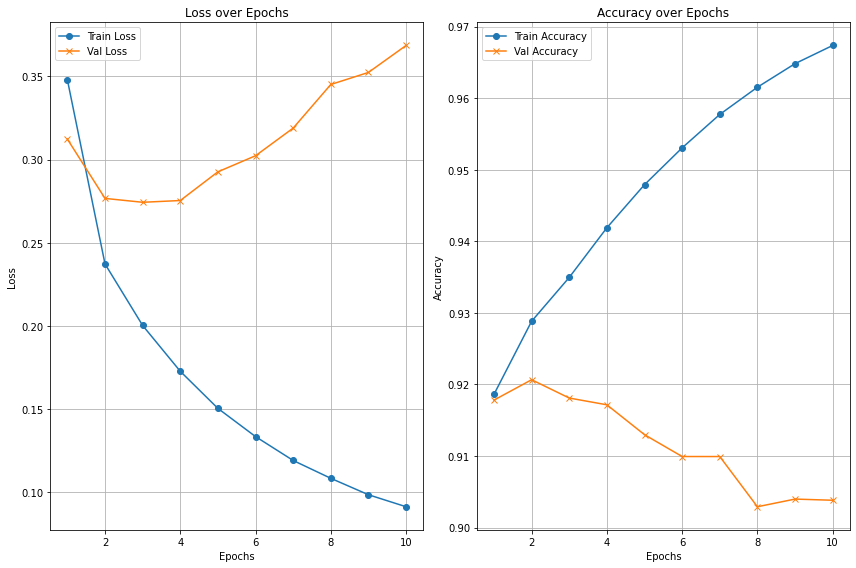

In [32]:
import matplotlib.pyplot as plt
epochs = np.arange(1, len(train_loss) + 1)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label = 'Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Loss over Epochs')
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Val Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.show()

# Encoder-Decoder Model

### Preprocesing For Question Answering

In [33]:
class QuestionAnsewring(object):
    def __init__(self, dataset:dict, map:dict) -> None:
        """
            Pass the Dataset and the vocab model.
        """
        self.txt = copy.deepcopy(dataset['text'])
        self.labels = copy.deepcopy(dataset['srl_frames'])
        self.verb_indexes = copy.deepcopy(dataset['verb_index'])
        self.srl_mapping = mapper_dict
        self.questions = []
        self.answering = []
        self.map = map
        self.label_maps = ['ARG0', 'ARG1', 'ARG2', 'ARGM-LOC', 'ARGM-TMP']
    
    def mapping_labels(self) -> None:
        """
            Map the labels to simplicity
        """
        for i,label_list in enumerate(self.labels):
            for j,label in enumerate(label_list):
                self.labels[i][j] = self.map[label]

    def make_quesiton_answering(self, index) -> None:
        sentence = self.txt[index]
        verb_index = self.verb_indexes[index]
        labels = self.labels[index]           
        for tag in self.label_maps:
            question = [sentence[verb_index], '[SEPT]']
            question.extend(sentence)
            answering = []
            question.extend([tag])
            if tag in labels:
                answering.extend(['<Start>'])
                for i, label in enumerate(labels):
                    if label == tag:
                        answering.extend([sentence[i]])
                answering.extend(['<End>'])
            else:
                answering.extend(['<Start>', '<End>'])
            self.questions.append(question)
            self.answering.append(answering)
    
    def get_dataset(self):
        """
            Creating 5 question for each tag with text and verb indexes
        """
        for index in tqdm(range(len(self.txt))):
            self.make_quesiton_answering(index)
        return self.questions, self.answering

### Create a mapping to concatenate the arguments in easy way

In [34]:
mapping = {
    'O': 'O',
    'B-ARG0': 'ARG0',
    'I-ARG0': 'ARG0',
    'B-ARG1': 'ARG1',
    'I-ARG1': 'ARG1',
    'B-ARG2': 'ARG2',
    'I-ARG2': 'ARG2',
    'B-ARGM-LOC': 'ARGM-LOC',
    'I-ARGM': 'ARGM-LOC',
    'B-ARGM-TMP':'ARGM-TMP',
    'I-ARGM-TMP': 'ARGM-TMP'
}

### Make Question Answering based on trainin set

In [35]:
qa_dataset = QuestionAnsewring(dataset=train_set, map=mapping)
qa_dataset.labels

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ARG0',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'B-ARG1', 'O', 'B-ARG2', 'I-ARG2', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'B-ARG1',
  'I-ARG1',
  'I-ARG1',
  'I-ARG1',
  'I-ARG1',
  'B-ARG0',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ARG0',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'B-ARG1',
  'I-ARG1',
  'I-ARG1',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O

In [36]:
qa_dataset.mapping_labels()
qa_dataset.labels

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ARG1', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'ARG0',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'ARG1', 'O', 'ARG2', 'ARG2', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'ARG1',
  'ARG1',
  'ARG1',
  'ARG1',
  'ARG1',
  'ARG0',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'ARG0',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'ARG1',
  'ARG1',
  'ARG1',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
 

In [37]:
questions, answerings = qa_dataset.get_dataset()

100%|██████████| 13310/13310 [00:00<00:00, 31310.66it/s]


In [38]:
print(f'The quesitons are: {questions[:10]}')
print(f'The asnwers are: {answerings[:10]}')

The quesitons are: [['inscribed', '[SEPT]', 'A', 'primary', 'stele', ',', 'three', 'secondary', 'steles', ',', 'and', 'two', 'inscribed', 'steles', '.', 'ARG0'], ['inscribed', '[SEPT]', 'A', 'primary', 'stele', ',', 'three', 'secondary', 'steles', ',', 'and', 'two', 'inscribed', 'steles', '.', 'ARG1'], ['inscribed', '[SEPT]', 'A', 'primary', 'stele', ',', 'three', 'secondary', 'steles', ',', 'and', 'two', 'inscribed', 'steles', '.', 'ARG2'], ['inscribed', '[SEPT]', 'A', 'primary', 'stele', ',', 'three', 'secondary', 'steles', ',', 'and', 'two', 'inscribed', 'steles', '.', 'ARGM-LOC'], ['inscribed', '[SEPT]', 'A', 'primary', 'stele', ',', 'three', 'secondary', 'steles', ',', 'and', 'two', 'inscribed', 'steles', '.', 'ARGM-TMP'], ['coordinated', '[SEPT]', 'The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.', 'ARG0'], ['coordinated', '[SEPT]', 'The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'v

In [39]:
print(len(questions), len(answerings))

66550 66550


### Make Question Anwering for validation

In [40]:
qa_validset = QuestionAnsewring(dataset=valid_set, map=mapping) 
qa_validset.mapping_labels()
valid_qustions, valid_answering = qa_validset.get_dataset()
print(len(valid_answering), len(valid_qustions))

100%|██████████| 800/800 [00:00<00:00, 114258.97it/s]

4000 4000


### Add Glove vectors 

In [41]:
glove_embdedding = {}
with open('Glove\glove.6B.300d.txt', 'r') as my_file:
    for line in my_file:
        values = line.split()
        glove_embdedding[values[0]] = np.asarray(values[1:], dtype=float)
special_tokens = ['<Start>', '<End>', '[SEPT]']
for token in special_tokens:
    if token in glove_embdedding:
        print(glove_embdedding[token].shape)
    else:
        print(f'The {token} is not in the GLOVE vectors')

The <Start> is not in the GLOVE vectors
The <End> is not in the GLOVE vectors
The [SEPT] is not in the GLOVE vectors


### First Create class for Encoder with Bidirectional LSTM 

In [42]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim, encoder_hidden_dim, pretrained_embeddings):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, encoder_hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(encoder_hidden_dim*2, encoder_hidden_dim)
        self.fc2 = nn.Linear(encoder_hidden_dim*2, encoder_hidden_dim)
    
    def forward(self, src):
        embedded = self.embedding(src)
        encoder_outputs, (hidden, cell) = self.lstm(embedded)
        hidden = torch.tanh(self.fc1(torch.cat((hidden[0, :, :],hidden[1, :, :]), dim=1)))
        cell = torch.tanh(self.fc2(torch.cat((cell[0,:,:], cell[1, :, :]), dim=1)))
        return encoder_outputs, hidden.unsqueeze(0), cell.unsqueeze(0)

### Create Attention Mechansim

In [43]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(encoder_hidden_dim * 2 + decoder_hidden_dim, decoder_hidden_dim)
        self.v = nn.Parameter(torch.rand(decoder_hidden_dim))

    def forward(self, decoder_hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((decoder_hidden, encoder_outputs), dim=2)))
        energy = energy.permute(0, 2, 1)

        attn_scores = torch.matmul(self.v, energy)
        return torch.softmax(attn_scores, dim=1)

### Create Decoder

In [44]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, output_dim, pretrained_embedding) -> None:
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=False)
        self.attention = Attention(encoder_hidden_dim, decoder_hidden_dim)
        self.lstm = nn.LSTM(encoder_hidden_dim * 2 + embedding_dim, decoder_hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(decoder_hidden_dim, output_dim)
    
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        attn_applied = torch.matmul(attn_weights.unsqueeze(1), encoder_outputs)
        lstm_inptut = torch.cat((embedded, attn_applied), dim=2)
        lstm_output, (hidden, cell) = self.lstm(lstm_inptut, (hidden, cell))
        output = self.fc_out(lstm_output)
        return output, hidden, cell, attn_weights

### Create Seq2Seq class

In [45]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device) -> None:
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_ouptus, hidden, cell = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_ouptus)
            outputs[:, t, :] = output.squeeze(1)
            teacher_force = np.random.rand() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.squeeze(1).argmax(1)
            
        return outputs
    
    def beam_search(self, src, beam_width=16, max_len=6):
        self.encoder.eval()
        self.decoder.eval()
        
        with torch.no_grad():
            encoder_outputs, hidden, cell = self.encoder(src)
            inputs = torch.ones(src.shape[0], dtype=torch.long, device=device) * 1
            
            beams = [(inputs, hidden, cell, 0)]
            
            for _ in range(max_len):
                candidates = []
                for seq, h, c, score in beams:
                    output, h_next, c_next, _ = self.decoder(seq.unsqueeze(0), h, c, encoder_outputs)
                    log_probs = F.log_softmax(output, dim=-1).squeeze(0) 
                    top_log_probs, top_idxs = log_probs.topk(beam_width) 
                    
                    # Create new candidates and add to candidates list
                    for i in range(beam_width):
                        next_seq = torch.cat([seq, top_idxs[:, i]])
                        next_score = score + top_log_probs[:, i]
                        candidates.append((next_seq, h_next, c_next, next_score))
                
                # Sort all candidates by score, pick the best beam_width ones
                candidates.sort(key=lambda x: -x[3])  # Sort by score in descending order
                beams = candidates[:beam_width]
            
            # Choose the best sequence
            best_seq = beams[0][0]
            return best_seq

### Class of dataset

In [46]:
class QAdataset(Dataset):
    def __init__(self, questions:list[list[str]], answers:list[list[str]]):
        """
            Construct with questions and aswers
        """
        self.quests = questions
        self.answs = answers
        print(len(questions))
        print(len(answers))
    
    def __len__(self):
        return len(self.quests)

    def __getitem__(self, index):
        return self.quests[index], self.answs[index]

### Create Vocab based on the question answerings

In [47]:
all_questions_answer = copy.deepcopy(questions)
for answer in answerings:
    all_questions_answer.append(answer)
print(len(questions), len(answerings))

66550 66550


In [48]:
vocab = from_corpus(all_questions_answer, size=20000, remove_frac=0.2, freq_cutoff=1)

In [49]:
len(vocab)

15274

### Assign Glove vectors as embeddings

In [50]:
embds = tensor([[0 for _ in range(300)] for __ in range(len(vocab))], dtype=torch.float)
count = 0
for key,value in vocab.word2id.items():
    if key in glove_embdedding:
        embds[value] = torch.from_numpy(glove_embdedding[key]).long()
    else:
        embds[value] = torch.rand(embds.shape[1]).reshape((embds.shape[1]))
embds[vocab['<PAD>']] = torch.zeros((1,embds.shape[1]))
embds[vocab['<Unknown>']] = torch.mean(embds, dim=0, keepdim=True, dtype=float).squeeze(0)
embds.dtype

torch.float32

#### Collate Batch

In [51]:
def collate_batch(batch, vocab):
    input_ids = []
    outptut_ids = []
    for b in batch:
        input_ids.append(copy.deepcopy(b[0]))
        outptut_ids.append(copy.deepcopy(b[1]))
    return vocab.to_input_tensor(input_ids), vocab.to_input_tensor(outptut_ids)

In [52]:
train_qa_dataset = QAdataset(questions, answerings)
train_dataloader = DataLoader(train_qa_dataset, batch_size=64, shuffle=True, drop_last=True, collate_fn=lambda batch: collate_batch(batch, vocab))

66550
66550


In [53]:
valid_qa_dataset = QAdataset(valid_qustions, valid_answering)
valid_dataloader = DataLoader(valid_qa_dataset, batch_size=64, shuffle=True, drop_last=True, collate_fn=lambda batch: collate_batch(batch, vocab))

4000
4000


### Define Hyperparameters

In [54]:
vocab_size = len(vocab)
embedding_dim = 300
encoder_hidden_dim = 64
decoder_hidden_dim = 64
output_dim = len(vocab)

In [55]:
encoder = Encoder(
    embedding_dim=embedding_dim,
    encoder_hidden_dim=encoder_hidden_dim,
    pretrained_embeddings=embds
)
decoder = Decoder(
    embedding_dim=embedding_dim,
    encoder_hidden_dim=encoder_hidden_dim,
    decoder_hidden_dim=decoder_hidden_dim,
    output_dim=output_dim,
    pretrained_embedding=embds
)
model = Seq2Seq(encoder=encoder, decoder=decoder, device="cuda")
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [56]:
model.parameters()

<generator object Module.parameters at 0x00000199260EF3E0>

In [57]:
# def init_weigths(m):
#     for name, param in m.named_parameters():
#         if name != 'encoder.embedding.weight' and name != 'decoder.embedding.weight':
#             torch.nn.init.uniform_(param.data, -0.08, 0.08)
# model.apply(init_weigths)

### Validation function

In [58]:
def validate(model, loss_fn, val_loader, device):
    model.eval()
    validation_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, output_ids = batch[0].to(device), batch[1].to(device)
            preds = model(input_ids, output_ids, 0)
            output_dim = preds.shape[-1]
            output = preds.reshape(-1, output_dim)
            output_ids = output_ids.reshape(-1)
            loss = loss_fn(output, output_ids.to(torch.long))
            validation_loss += loss.item()
            _, predicted_indices = torch.max(output, dim=1)
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(output_ids.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Valdiation Loss: {validation_loss/len(val_loader):.2f}, Validation Accuaracy: {accuracy:.2f}')
    return validation_loss/len(val_loader), accuracy, all_preds, all_labels

### Training Loops

In [59]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device="cuda", teacher_frocing_ratio=0.5):
    model.to(device)
    training_loss_per_epoch = []
    accuracy_per_epoch = []
    validation_loss_per_epoch = []
    validation_acc_per_epoch = []
    val_preds = []
    val_labels = []
    for epoch in range(epochs):
        training_loss = 0.0
        model.train()
        all_preds = []
        all_labels = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids, output_ids = batch[0].to(device), batch[1].to(device)
            preds = model(input_ids, output_ids, teacher_frocing_ratio)
            output_dim = preds.shape[-1]
            output = preds.reshape(-1, output_dim)
            output_ids = output_ids.reshape(-1)
            loss = loss_fn(output, output_ids.to(torch.long))
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            _, predicted_indices = torch.max(output, dim=1)
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(output_ids.cpu().numpy())
        training_loss = training_loss / len(train_loader)
        training_loss_per_epoch.append(training_loss)
        accuracy_per_epoch.append(accuracy_score(all_labels, all_preds))
        print(f'Epoch: {epoch}, training_loss: {training_loss:.2f}, training_accuracy: {accuracy_score(all_labels, all_preds):.2f}')
        val_loss, val_acc, val_preds, val_labels = validate(model, loss_fn, val_loader, device)
        validation_loss_per_epoch.append(val_loss), validation_acc_per_epoch.append(val_acc)
    print(classification_report(val_labels, val_preds))
    return training_loss_per_epoch, accuracy_per_epoch, validation_loss_per_epoch, validation_acc_per_epoch

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [61]:
epochs = 10
train_loss, train_acc, val_loss, val_acc = train(model, optimizer, loss_fn, train_dataloader, valid_dataloader, epochs, device)

100%|██████████| 1039/1039 [00:44<00:00, 23.39it/s]


Epoch: 0, training_loss: 2.16, training_accuracy: 0.78
Valdiation Loss: 1.94, Validation Accuaracy: 0.78


100%|██████████| 1039/1039 [00:41<00:00, 24.92it/s]


Epoch: 1, training_loss: 1.86, training_accuracy: 0.79
Valdiation Loss: 2.03, Validation Accuaracy: 0.78


100%|██████████| 1039/1039 [00:42<00:00, 24.38it/s]


Epoch: 2, training_loss: 1.83, training_accuracy: 0.80
Valdiation Loss: 1.99, Validation Accuaracy: 0.78


100%|██████████| 1039/1039 [00:55<00:00, 18.70it/s]


Epoch: 3, training_loss: 1.82, training_accuracy: 0.80
Valdiation Loss: 2.02, Validation Accuaracy: 0.78


100%|██████████| 1039/1039 [00:43<00:00, 23.97it/s]


Epoch: 4, training_loss: 1.80, training_accuracy: 0.80
Valdiation Loss: 2.01, Validation Accuaracy: 0.78


100%|██████████| 1039/1039 [01:21<00:00, 12.82it/s]


Epoch: 5, training_loss: 1.77, training_accuracy: 0.80
Valdiation Loss: 2.05, Validation Accuaracy: 0.78


100%|██████████| 1039/1039 [00:56<00:00, 18.42it/s]


Epoch: 6, training_loss: 1.74, training_accuracy: 0.80
Valdiation Loss: 1.94, Validation Accuaracy: 0.79


100%|██████████| 1039/1039 [00:39<00:00, 26.17it/s]


Epoch: 7, training_loss: 1.74, training_accuracy: 0.80
Valdiation Loss: 1.97, Validation Accuaracy: 0.79


100%|██████████| 1039/1039 [00:42<00:00, 24.66it/s]


Epoch: 8, training_loss: 1.72, training_accuracy: 0.80
Valdiation Loss: 2.06, Validation Accuaracy: 0.78


100%|██████████| 1039/1039 [00:42<00:00, 24.31it/s]


Epoch: 9, training_loss: 1.69, training_accuracy: 0.81
Valdiation Loss: 2.00, Validation Accuaracy: 0.79
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     27168
           1       0.00      0.00      0.00      3968
           2       0.68      0.75      0.72      3968
           3       0.00      0.00      0.00       277
         150       0.00      0.00      0.00         3
         227       0.00      0.00      0.00         1
         718       0.00      0.00      0.00         1
         775       0.00      0.00      0.00         1
         864       0.00      0.00      0.00         1
         866       0.00      0.00      0.00         1
        1020       0.00      0.00      0.00         1
        1101       0.00      0.00      0.00         1
        1298       0.00      0.00      0.00         1
        1323       0.00      0.00      0.00         1
        1325       0.00      0.00      0.00         1
        1500       0.00      0

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


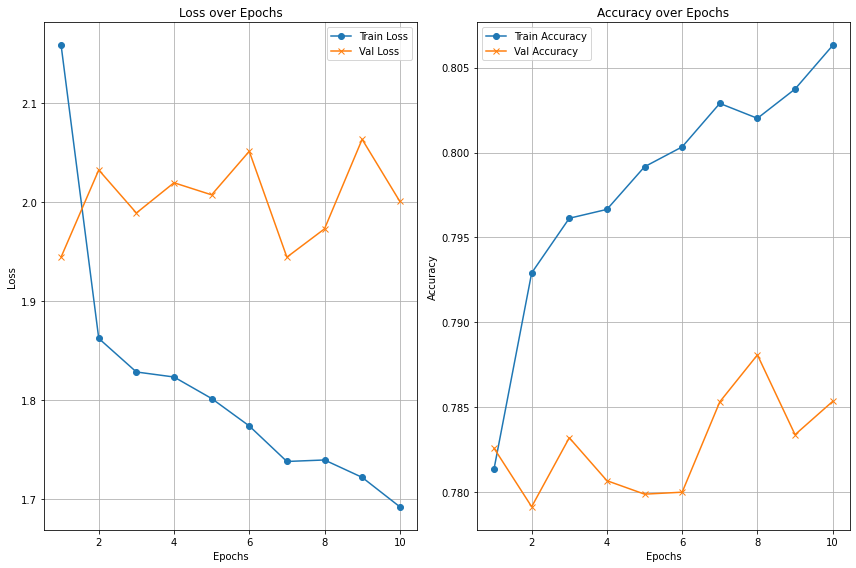

In [62]:
import matplotlib.pyplot as plt
epochs = np.arange(1, len(train_loss) + 1)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label = 'Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Loss over Epochs')
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Val Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.show()

In [63]:
# vocab.id2word[15202]

### Qualify

In [64]:
valid_example = {
    'text': valid_set['text'][0:2],
    'verb_index': valid_set['verb_index'][0:2],
    'srl_frames': valid_set['srl_frames'][0:2]
}

In [65]:
vocab = from_corpus(train_set['text'], size=20000, remove_frac=0.3, freq_cutoff=1)
val_dataset = Custom_Dataset(valid_example)
val_loader = DataLoader(val_dataset, batch_size=2, collate_fn=lambda batch: collate_batch_1(batch, vocab, mapper_dict))

In [66]:
batch = next(iter(val_loader))
predictions = my_lstm(batch[0].to(device), batch[1].to(device))
predictions = predictions.argmax(dim=2).tolist()

In [67]:
inverse_mapped_dict = {value:key for key,value in mapper_dict.items()}
mapped_predictions = [[inverse_mapped_dict[i] for i in pred] for pred in predictions]
print(f'predictions are: {mapped_predictions}')
print(f'Real labes are: {[[inverse_mapped_dict[i] for i in lab] for lab in batch[2].cpu().tolist()]}')

predictions are: [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG0', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]
Real labes are: [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG0', 'O', 'B-ARGM-TMP', 'O', 'O', 'B-ARG1', 'I-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


In [68]:
vocab = from_corpus(all_questions_answer, size=20000, remove_frac=0.2, freq_cutoff=1)
qa_validset = QuestionAnsewring(dataset=valid_example, map=mapping) 
qa_validset.mapping_labels()
valid_qustions, valid_answering = qa_validset.get_dataset()
print(len(valid_answering), len(valid_qustions))
val_dataset = QAdataset(valid_qustions, valid_answering)
val_loader = DataLoader(val_dataset, batch_size=10, collate_fn=lambda batch: collate_batch(batch, vocab))

100%|██████████| 2/2 [00:00<?, ?it/s]

10 10
10
10


In [69]:
batch = next(iter(val_loader))
print(batch[0].shape)

torch.Size([10, 30])


In [70]:
predictions = model(batch[0].to(device), batch[1].to(device), teacher_forcing_ratio=0)
predictions = predictions.argmax(dim=2)

In [71]:
predictions = vocab.indices2words(predictions.cpu().numpy().tolist())
print(f'Predictions are: {predictions}')

Predictions are: [['<PAD>', 'the', '<End>', '<PAD>', '<PAD>'], ['<PAD>', 'the', '<End>', '<PAD>', '<PAD>'], ['<PAD>', '<End>', '<PAD>', '<PAD>', '<PAD>'], ['<PAD>', '<End>', '<PAD>', '<PAD>', '<PAD>'], ['<PAD>', '<End>', '<PAD>', '<PAD>', '<PAD>'], ['<PAD>', '<End>', '<PAD>', '<PAD>', '<PAD>'], ['<PAD>', 'it', '<End>', '<PAD>', '<PAD>'], ['<PAD>', '<End>', '<End>', '<PAD>', '<PAD>'], ['<PAD>', '<End>', '<PAD>', '<PAD>', '<PAD>'], ['<PAD>', '<End>', '<PAD>', '<PAD>', '<PAD>']]
